In [1]:
import pandas as pd
import numpy as np
from pmo_forecasting.core.settings import settings
from pmo_forecasting.data.handler import DataHandler
import pmo_forecasting.forecasting.data_preparation as dp

In [2]:
df = DataHandler.from_registry(
    "DATA", "processed_dir", "processed_prices_data.csv").load()


In [3]:
BACKTEST_START = settings.config["backtesting"]["period"]["start"]
BACKTEST_END=settings.config["backtesting"]["period"]["end"]
df["date"] = pd.to_datetime(df["date"], utc=True)
df["date"] = df["date"].dt.tz_localize(None).dt.normalize()
prices = df.pivot(
    index="date",
    columns="ticker",
    values="close"
).loc[BACKTEST_START:BACKTEST_END]

In [4]:
prices

ticker,BND,SPY,TSLA
date,,,
2025-01-02,71.940002,584.640015,379.279999
2025-01-03,71.849998,591.950012,410.440002
2025-01-06,71.779999,595.359985,411.049988
2025-01-07,71.529999,588.630005,394.359985
2025-01-08,71.610001,589.489990,394.940002
...,...,...,...
2026-01-08,74.129997,689.510010,435.799988
2026-01-09,74.290001,694.070007,445.010010
2026-01-12,74.220001,695.159973,448.959991


In [5]:
returns = prices.pct_change().dropna()

In [6]:
def portfolio_returns(returns, weights):
    w = np.array([weights[c] for c in returns.columns])
    return returns @ w

In [8]:
strategy_weights = {
    "TSLA": 0.30,
    "SPY": 0.644,
    "BND": 0.506
}
benchmark_weights = {
    "SPY": 0.60,
    "BND": 0.40
}

In [9]:
strategy_assets = list(strategy_weights.keys())
benchmark_assets = list(benchmark_weights.keys())

strategy_ret = portfolio_returns(
    returns[strategy_assets],
    strategy_weights
)

benchmark_ret = portfolio_returns(
    returns[benchmark_assets],
    benchmark_weights
)

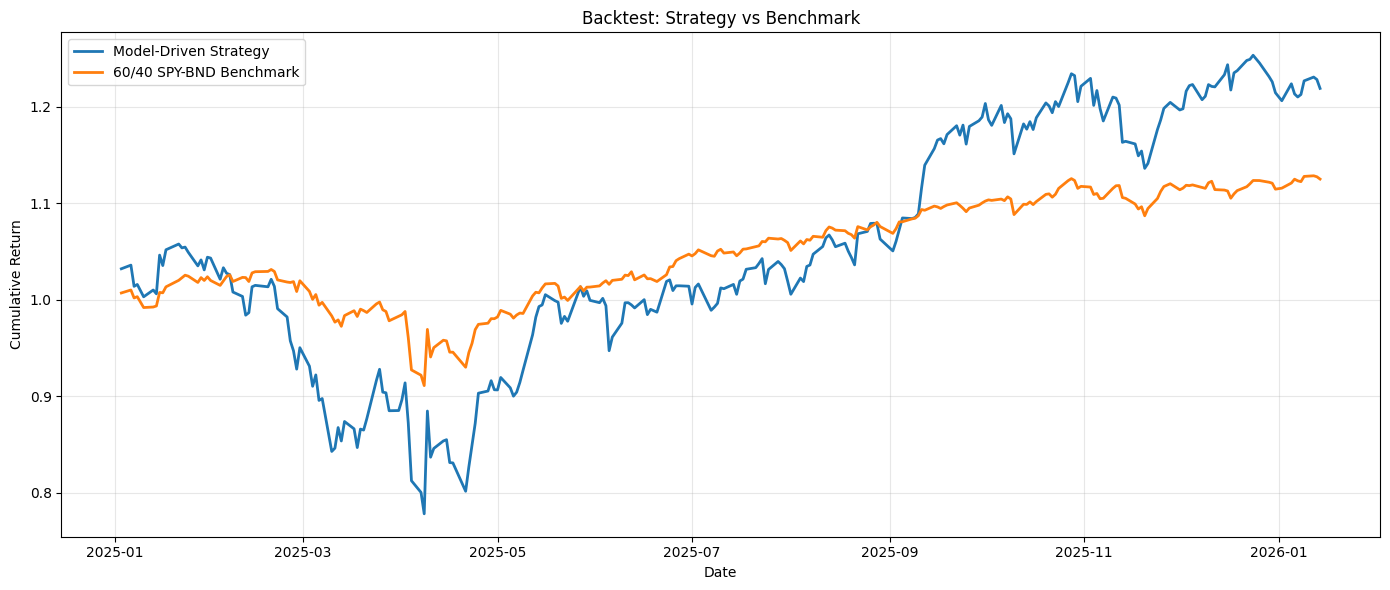

In [10]:
import matplotlib.pyplot as plt

strategy_cum = (1 + strategy_ret).cumprod()
benchmark_cum = (1 + benchmark_ret).cumprod()

plt.figure(figsize=(14, 6))
plt.plot(strategy_cum, label="Model-Driven Strategy", linewidth=2)
plt.plot(benchmark_cum, label="60/40 SPY-BND Benchmark", linewidth=2)

plt.title("Backtest: Strategy vs Benchmark")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
def sharpe_ratio(returns, rf=0.0):
    return np.sqrt(252) * (returns.mean() - rf) / returns.std()


def max_drawdown(cum_returns):
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    return drawdown.min()

In [12]:
metrics = pd.DataFrame({
    "Strategy": {
        "Total Return": strategy_cum.iloc[-1] - 1,
        "Annualized Return": strategy_ret.mean() * 252,
        "Sharpe Ratio": sharpe_ratio(strategy_ret),
        "Max Drawdown": max_drawdown(strategy_cum)
    },
    "Benchmark": {
        "Total Return": benchmark_cum.iloc[-1] - 1,
        "Annualized Return": benchmark_ret.mean() * 252,
        "Sharpe Ratio": sharpe_ratio(benchmark_ret),
        "Max Drawdown": max_drawdown(benchmark_cum)
    }
})

metrics

,Strategy,Benchmark
Total Return,0.219032,0.125053
Annualized Return,0.234659,0.122052
Sharpe Ratio,0.811479,1.030498
Max Drawdown,-0.264358,-0.116707


| Metric                | Strategy   | Benchmark  |
| --------------------- | ---------- | ---------- |
| **Total Return**      | **21.9%**  | 12.5%      |
| **Annualized Return** | **23.5%**  | 12.2%      |
| **Sharpe Ratio**      | **0.81**   | **1.03**   |
| **Max Drawdown**      | **−26.4%** | **−11.7%** |


The strategy delivers materially higher absolute and annualized returns than the benchmark, demonstrating strong return-generating capability. However, this outperformance is achieved with significantly higher volatility and deeper drawdowns, resulting in inferior risk-adjusted performance as reflected by the lower Sharpe ratio. Consequently, while attractive for aggressive, return-seeking investors, the strategy entails elevated downside risk relative to the benchmark.